# Analysis Jupyter Notebook
#### Controlla il path della cartella

## Data Handling
### Creation of the aggregation matrix and indexing the fibrils

In [1]:
# 2000 peptidi

import gromacs
from gromacs.fileformats import *
from gromacs import cbook
import string
import numpy as np

concentration = 13
n_molecules = 2000

### Command for clustsize
!{'rm \#*'}
clust_cmd = 'gmx_mpi clustsize -f prod_2000-13mM.xtc -dt 1000 -s prod_2000-13mM.tpr -mol -hct -nice 0 -cut 0.4'
print(clust_cmd)
#!{clust_cmd}
!{'rm \#*'}
#!{"sed -i 's/clust /clust_/g' maxclust.ndx"}

#print(gromacs.release())



rm: cannot remove '#*': No such file or directory
gmx_mpi clustsize -f prod_2000-13mM.xtc -dt 1000 -s prod_2000-13mM.tpr -mol -hct -nice 0 -cut 0.4
rm: cannot remove '#*': No such file or directory


### Extraction of the cluster information from maxclust.ndx

In [2]:
### Import the index as uniqueNDX to perform some operations
maxclust_ndx = NDX('maxclust.ndx')

### Creation of a dictionary which includes the index names and the atomnumber
maxclust_dict = maxclust_ndx.sizes

#print('Dictionary obtained from maxclust.ndx\n', maxclust_dict)

### Extraction of all the clusters, remove the max_clust (duplicated) and make a list of them
fibril_dict = {key:val for key, val in maxclust_dict.items() if val != 85}
fibril_list = list(fibril_dict.keys())
fibril_list.remove('max_clust_')

### Extraction of all the single molecules not part of a fibril and make a list of that
not_fibril_dict = {key:val for key, val in maxclust_dict.items() if val == 85}
not_fibril_list = list(not_fibril_dict.keys())

#print('Dictionary containing the fibril\n', fibril_dict)
print('List containing the fibril\n', fibril_list)
#print(not_fibril_dict)
#print('List of not fibril\n', not_fibril_list)




List containing the fibril
 ['clust_1580', 'clust_224', 'clust_349', 'clust_636']


### Creation of a new clean index for chain labelling containing only the clusters and all the peptides in one single group at the end

In [3]:
np.set_printoptions(threshold=sys.maxsize)
pdb_temp_ndx = open('pdb_temp.ndx', 'w')

check_len = []

for f in fibril_list:
    pdb_temp_ndx.write(f'({f}) \n')
    print(f'{f} added in pdb_temp.ndx')

    atom_array =  maxclust_ndx.get(f)
    pdb_temp_ndx.write(str(atom_array) + '\n\n')
    check_len.append(len(atom_array))
    print(f'Containing {len(atom_array)} atoms\n and {len(atom_array)/85} chains')

pdb_temp_ndx.write(f'(not_fibril) \n')
for nf in not_fibril_list:
    atom_array =  maxclust_ndx.get(nf)
    pdb_temp_ndx.write(str(atom_array) + '\n')
    check_len.append(len(atom_array))

print(f'Added {len(not_fibril_list)} peptides in pdb_temp.ndx')
pdb_temp_ndx.close()

with open('pdb_temp.ndx', 'r') as infile, open('pdb.ndx', 'w') as outfile:
    data = infile.read()
    data = data.replace("[", " ")
    data = data.replace("]", " ")
    data = data.replace("(", "[")
    data = data.replace(")", "]")
    outfile.write(data)

print('pdb_temp.ndx renamed to pdb.ndx with corrections')
!{'rm pdb_temp.ndx'}

if (sum(check_len)/85) == n_molecules:
    print(f'\n\n\n\nThere are {sum(check_len)} atoms, equals to {int(sum(check_len)/85)}\nCORRECT\n\n\n\n')
else:
    print('SOMETHING IS VERY WRONG')


clust_1580 added in pdb_temp.ndx
Containing 141695 atoms
 and 1667.0 chains
clust_224 added in pdb_temp.ndx
Containing 170 atoms
 and 2.0 chains
clust_349 added in pdb_temp.ndx
Containing 170 atoms
 and 2.0 chains
clust_636 added in pdb_temp.ndx
Containing 170 atoms
 and 2.0 chains
Added 327 peptides in pdb_temp.ndx
pdb_temp.ndx renamed to pdb.ndx with corrections




There are 170000 atoms, equals to 2000
CORRECT






In [4]:
### Print the values to print into the script
array1 = list(range(0, (len(fibril_list)+1)))
print(f'There are {len(fibril_list)-1} fibrils in trajectory. Group number {len(fibril_list)} contains all peptides not bound\n',array1, '\n')

array2 = list(map(chr, range(97, (97+len(array1)))))
print(f'The chain labels are the following: {array2}\nas "{array2[-1]}" containing the not bound peptides')

There are 3 fibrils in trajectory. Group number 4 contains all peptides not bound
 [0, 1, 2, 3, 4] 

The chain labels are the following: ['a', 'b', 'c', 'd', 'e']
as "e" containing the not bound peptides


### Script for chain labelling

In [5]:


for a1, a2 in zip(array1, array2):
    print(a1, a2)#.upper()) # Se le vuoi tutte maiuscole

    # For each fibril you want to obtain the pdb and the esp files.
    string_pdb = f'echo -e {a1} \\n | gmx_mpi editconf -f prod_{n_molecules}-{concentration}mM.tpr -n pdb.ndx -label {a2} -o clust_prova{a1}.pdb'
    string_esp = f'echo -e {a1} \\n | gmx_mpi editconf -f prod_{n_molecules}-{concentration}mM.tpr -n pdb.ndx -label {a2} -o clust_prova{a1}.esp'
    print(string_pdb)
    !{string_pdb}
    print(string_esp)
    !{string_esp}

    # Here the script takes the atom number from the esp file and paste into a temporary file    
    string_sed = f"sed 's/{{//' clust_prova{a1}.esp | awk '{{print $1+1}}' > numero{a1}"
    print(string_sed)
    !{string_sed}

    # Here you add a line with "1" to align the numbers with the correct atom to paste into the pdb
    string_sed2 = f"sed -i '1s/^/1\\n/' numero{a1}"
    print(string_sed2)
    !{string_sed2}

    # Here you paste the number in the pdb file and save into another temp file
    string_paste = f"paste numero{a1} clust_prova{a1}.pdb > chain{a1}"
    print(string_paste)
    !{string_paste}

    # This step append all the pdbs and extract only the atoms.
    # Also you sort the atoms based on their real atom number and save into a temporary pdb file full with the fibril and not-fibril

string_cat = "cat chain* | grep ATOM | sort -k1 -g > temp_label-chain.pdb"
print(string_cat)
!{string_cat}
string_rm = "rm numero* chain* clust*.esp"
print(string_rm)
!{string_rm}

# In this step you delete the first column which is the atom number from the esp file and save into the final pdb file

string_cut = "cut -f 1 --complement temp_label-chain.pdb > label-chain.pdb"
print(string_cut)
!{string_cut}

string_rm2 = "rm temp_label-chain.pdb"
print(string_rm2)
!{string_rm2}


string_mkdir = "mkdir clust_pdbs"
print(string_mkdir)
!{string_mkdir}

string_mv = "mv clust*.pdb clust_pdbs/"
print(string_mv)
!{string_mv}

!{'rm \#*'}





0 a
echo -e 0 \n | gmx_mpi editconf -f prod_2000-13mM.tpr -n pdb.ndx -label a -o clust_prova0.pdb
Invalid MIT-MAGIC-COOKIE-1 key                :-) GROMACS - gmx editconf, 2020.3-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      

### Matrix handling for fibril growth plots

In [6]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import ListedColormap

%pwd
%cd /media/data/emanuele/TTR/greta_test_cutoff_5_ex_1/epsilon_0345_gd_0/concentration_gradient/make_fibril_2000_e0345_gd_0_cutoff_5_ex_1_13mM_300K/analysis

### Data import

matrix = pd.read_csv('histo-time.dat', sep = '\\s+', header = None)

# Changing the index so now it is in picoseconds
#matrix[0] = matrix[0].apply(lambda x:x*10)
#matrix = matrix.set_index([0])

### Data handling
#### Defining the Maxclust and the number of frames
clustsize = list(range(0, len(matrix.columns), 1))
frames = list(range(0, len(matrix.index), 1))
fibril = list(range(2, len(matrix.columns)))
#not_fibril = list(range(3, 10, 1))


#### Multiply the columns for its clustsize
size = pd.Series(clustsize)
matrix = matrix.mul(size, axis = 1)

#### Replace 0 with n.an
matrix[matrix == 0] = np.nan

#### I don't care about monomers
matrix = matrix.drop([0, 1], axis = 1)

### Make the histogram to compare with lab results
# Set the not-fibril to 0 and have a sort of lag time 
histo_zero = matrix.copy()
histo_zero[[2, 3, 4, 5, 6, 7, 8, 9, 10]] = 0
histo_zero = histo_zero[fibril].sum(axis=1)

# This one is the complete one
histogram = matrix[fibril].sum(axis=1)

# Matrix transpose
matrix = matrix.T

#print(matrix.to_string())

/media/data/emanuele/TTR/greta_test_cutoff_5_ex_1/epsilon_0345_gd_0/concentration_gradient/make_fibril_2000_e0345_gd_0_cutoff_5_ex_1_13mM_300K/analysis


### Colvar analysis for plots

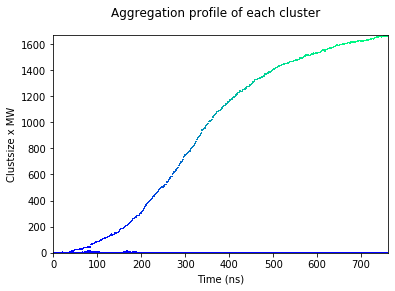

In [7]:
#prova = ListedColormap(['darkorange', 'gold', 'lawngreen', 'lightseagreen'])
plt.pcolormesh(matrix, cmap = 'winter', rasterized = True)
plt.ylabel('Clustsize x MW')
plt.xlabel('Time (ns)')
#plt.xlim(0, 2000)
plt.suptitle('Aggregation profile of each cluster')
plt.savefig('13mM_matrix.png', dpi = 800)
plt.show()


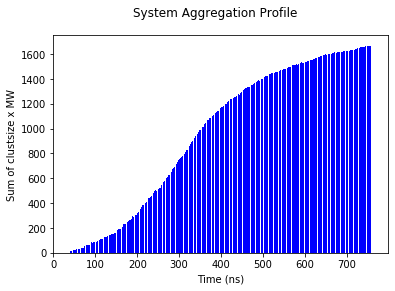

In [8]:
plt.bar(frames, histo_zero, color = 'blue', edgecolor = 'none')
plt.ylabel('Sum of clustsize x MW')
plt.xlabel('Time (ns)')
#plt.xlim(0, 2000)
plt.suptitle('System Aggregation Profile')
plt.savefig('13mM_histo.png', dpi = 800, figsize = (10,10))
plt.xlim(xmin=0)
plt.show()

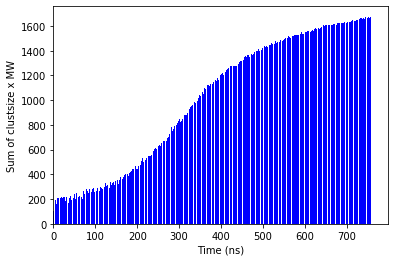

In [9]:
plt.bar(frames, histogram, color = 'blue')
plt.ylabel('Sum of clustsize x MW')
plt.xlabel('Time (ns)')
#plt.xlim(0, 1000)
plt.xlim(xmin=0)
plt.show()